# Example 3: Transforming Data
First we import the necessary modules and create reader +  writer object.

In [36]:
import pythermondt.transforms as T
from pythermondt.readers import LocalReader, S3Reader
from pythermondt import ThermoDataset

# Create data sources
localreader = LocalReader(source="./example_data/example-data*.hdf5")
s3reader = S3Reader("s3://ffg-bp/example2_writing_data/.hdf5")

Pythermondt supports applying transformations to the data. This is useful to easily manipulate the data before writing it to a file, for reccuring tasks. For example the lookup table can be applied:

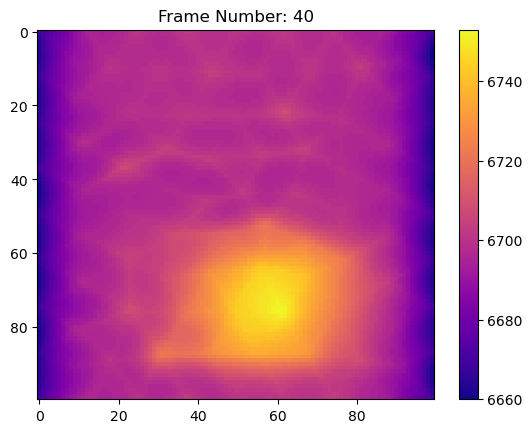

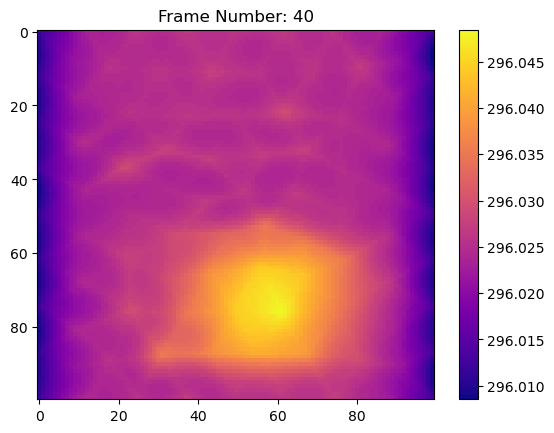

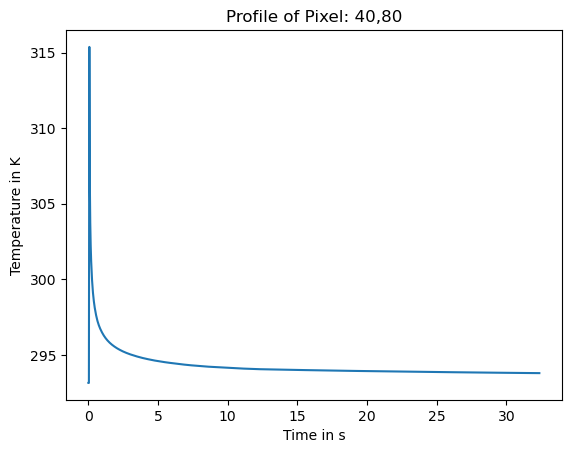

In [37]:
# Setup
container = localreader[2]
transform = T.ApplyLUT()

container.show_frame(40)

container = transform(container)

container.show_frame(40)
container.show_pixel_profile(40,80)

Composing multiple transformations into a single transformation is also possible using Compose:

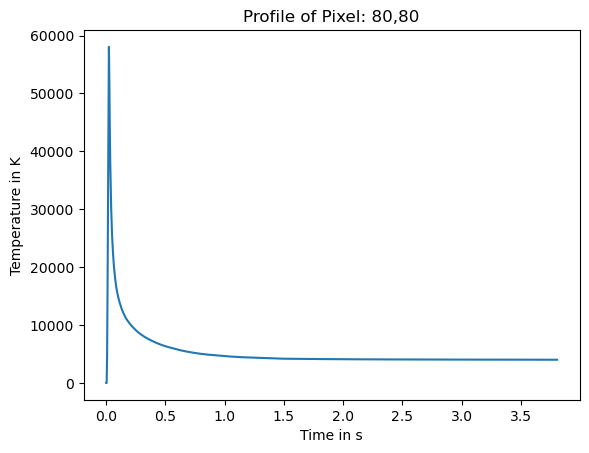

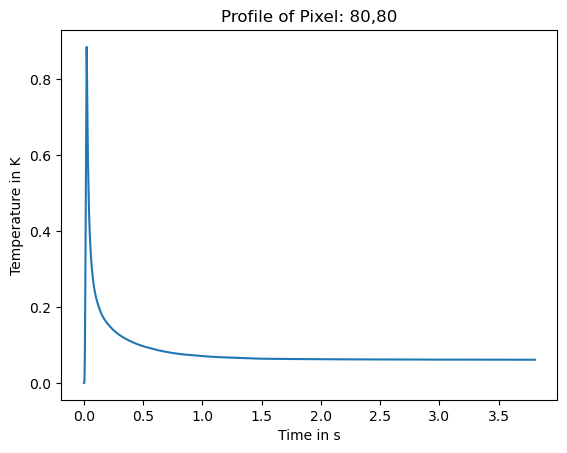

In [38]:
container = localreader[0]
pipeline = T.Compose([
    T.ApplyLUT(),
    T.SubstractFrame(frame=0),
    T.MinMaxNormalize(),
])

container.show_pixel_profile(80, 80)

container = pipeline(container) 

container.show_pixel_profile(80, 80)

Multiple readers can be combined using the ThermoDataset class. This is useful when you have files from different sources and you want to combine them into a single dataset. The ThermoDataset also supports transforms, which are applied to the data before it is read. Therefore the data is already transformed when it is read from the file system

In [39]:
# Create
dataset = ThermoDataset(data_source=[localreader, s3reader], transform=pipeline)

Indexmap Memory:  0.000152587890625 MB


The dataset now behaves like a single reader and can be used in the same way as a single reader.

Number of files in the localreader:  3
Number of files in the s3reader:  3
Number of files in the dataset:  6


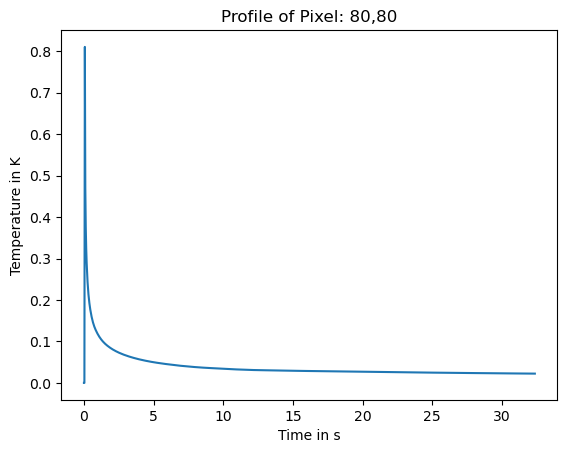

In [40]:
print("Number of files in the localreader: ", len(localreader))
print("Number of files in the s3reader: ", len(s3reader))
print("Number of files in the dataset: ", len(dataset))
dataset[5].show_pixel_profile(80, 80)

All transformations inherit from the nn.Module class in Pytorch and work similar to [torchvision.v2.transforms](https://pytorch.org/vision/main/auto_examples/transforms/plot_transforms_getting_started.html). The transformations are applied to the data in the forward pass. Therefore custom transforms can easily be created by inheriting from the base class ThermoTransform:

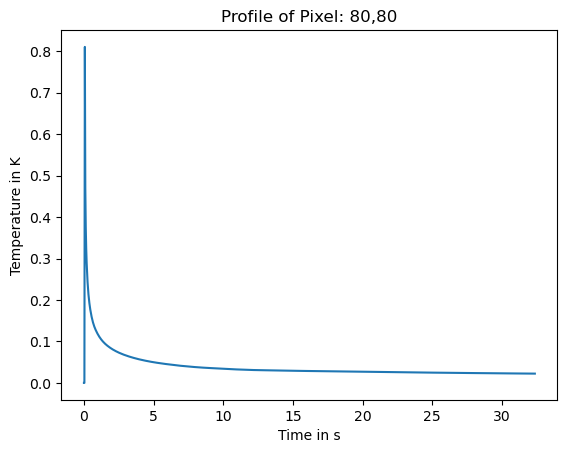

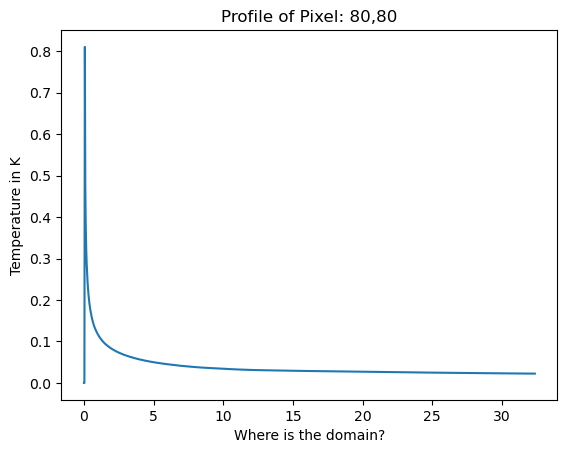

In [41]:
from pythermondt import DataContainer
from pythermondt.transforms import ThermoTransform

# Define a custom transform
class MyOwnTransform(ThermoTransform):
    def __init__(self, name: str):
        super().__init__()
        self.name = name

    def forward(self, container: DataContainer) -> DataContainer:
        container.update_attribute("/MetaData/DomainValues", "DomainType", self.name)
        return container
    
# Create a new instance of the custom transform
myowntransform = MyOwnTransform("Where is the domain?")

# Apply the custom transform
container = dataset[5]
container.show_pixel_profile(80, 80)

container = myowntransform(container) 

container.show_pixel_profile(80, 80)